# Introduction



Score-Based Models (SBM) are models of the log probability gradient, also called the score

$$ 
\mathbf{s}(\mathbf{x}) = \nabla_{\mathbf{x}} \log p(\mathbf{x})\,. 
$$

For an in-depth discussion of SBM's, I strongly suggest reading [Yang Song's blog post](https://yang-song.net/blog/2021/score/). 
This introduction will cover some of the same points, though with my own take on the subject.

### The normalization condition
First, a natural question that arises is: why not model the probability density function, $p(\mathbf{x})$, directly? 
For a probability density function to be valid, it must be normalized over its domain $\mathcal{X}$

$$
    \int_{\mathcal{X}} p(\mathbf{x}) d \mathbf{x} = 1\, .
$$

This, it turns out, is a very stringent condition. Not many functions have this property. 
Normalizing flows attempt to model probability densities by starting from a valid distribution, 
typically a Gaussian, and use a sequence of diffeomorphisms defined by neural networks 
with a tractable Jacobian to increase the expressivity of the model.
In this way, the normalization condition is guaranteed to be respected,
but the structure imposed on the neural network ultimately limits 
the expressivity and scalability of the framework.

Imposing the normalization condition as a soft-constraint (adding it to a loss function) is an obvious no-go. 
The integral is intractable in most cases of interest.
In general, 

$$\mathbf{x} \in \mathcal{X} \subseteq \mathbb{R}^n\,.$$ 

For images, $n > 10^4$ is typical. This is a problem.

### The score is local
By targeting the score, we sidestep the normalization condition entirely. To see this, 
consider that most of the distributions that interests us can be described by the Gibbs measure

$$
    p(\mathbf{x}) = \frac{1}{\mathcal{Z}} e^{- E(\mathbf{x}) }\, .
$$

All that has been done here is to suppose the existence of a positive-definite energy function, $E(\mathbf{x}) \geq 0$.
The distribution is now described via the energy function, so to speak.
The normalization condition is thus encoded in the partition function

$$
    \mathcal{Z} = \int_\mathcal{X} e^{-E(\mathbf{x})} d \mathbf{x}\, .
$$

The score of the Gibbs measure is a purely local description of the distribution, independent of the partition function

$$
    \nabla_{\mathbf{x}} \log p(\mathbf{x}) = - \nabla_{\mathbf{x}} E(\mathbf{x})\, .
$$

By modeling the score, $\mathbf{s}_\theta(\mathbf{x})$, using some neural network with parameters $\theta$, 
we can use any function with the signature 

$$
\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n\, .
$$

This is just a way to describe the dimension of the input and output of our function. 
Notice that the dimension of the input ($n$) and output ($n$) are the same. 
When we start adding conditional information, like the time-index of an SDE or some other inputs, 
we will expand the input signature of our function. 
In all cases, the output signature will remain the same, 
which is crucially equal to the dimension of $\mathcal{X} \subseteq \mathbb{R}^n$, 
where $\mathbf{x}$ belongs.

There is no other restriction on the architecture of our neural network, which allows us to use the full power of the 
universal approximation theorem for neural networks to model our distribution.

Allow me to emphasize this point through an example. First, consider a distribution with 4 well-separated Gaussian modes with equal weights.

In [1]:
!pip install --quiet score_models colorcet SciencePlots # For colab notebooks.
from score_models.plot_utils import *
from score_models.toy_distributions import *
from torch.func import grad, vmap

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
distribution = egg_box(4, mode_width=0.1, box_size=1)

def logp(x):
    return distribution.log_prob(x)

def score(x):
    return vmap(grad(logp))(x)

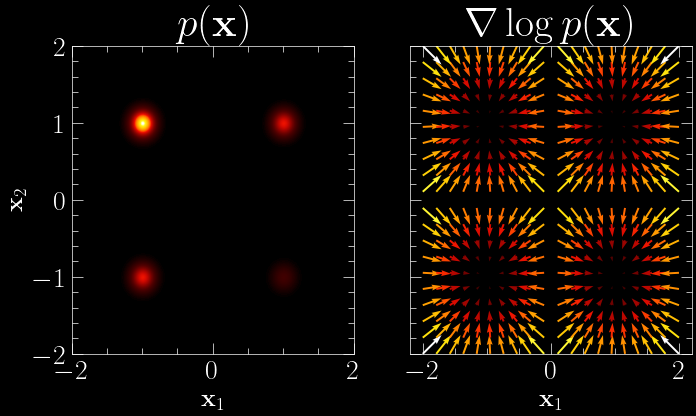

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

ax = axs[0]
plot_density(logp, ax=ax)
ax.set_title(r"$p(\mathbf{x})$")
ax.set_ylabel(r"$\mathbf{x}_2$")
ax.set_xlabel(r"$\mathbf{x}_1$");

ax = axs[1]
plot_score(score, ax=ax)
ax.set_title(r"$\nabla \log p(\mathbf{x})$")
ax.set_xlabel(r"$\mathbf{x}_1$");


The score is a vector field pointing toward regions of higher density. The farther from these regions one is, the larger the magnitude of the score. But, since the score is local, the magnitude does not depend on the relative magnitude of the mode.

In our example, we can change the weights of each mode, which will change the probability density picture on the left. But the magnitude or orientation of the score vector picture on the right does not change. 

In [7]:
distribution = egg_box(4, mode_width=0.1, box_size=1, weights=(1, 0.5, 0.5, 0.1))

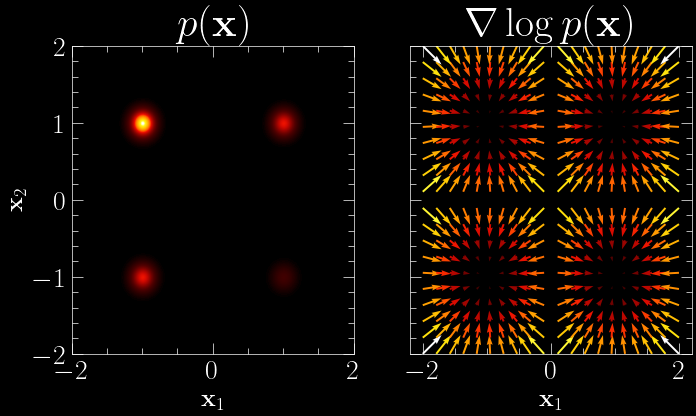

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

ax = axs[0]
plot_density(logp, ax=ax)
ax.set_title(r"$p(\mathbf{x})$")
ax.set_ylabel(r"$\mathbf{x}_2$")
ax.set_xlabel(r"$\mathbf{x}_1$");

ax = axs[1]
plot_score(score, ax=ax)
ax.set_title(r"$\nabla \log p(\mathbf{x})$")
ax.set_xlabel(r"$\mathbf{x}_1$");
